In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
import matplotlib.pyplot as plt


In [121]:
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras.layers import Activation,BatchNormalization,Flatten,MaxPooling2D,ZeroPadding2D
from tensorflow.keras.layers import Input,Conv2D,Conv2DTranspose,Dense,Reshape,Dropout,UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from scipy import misc
import numpy as np
import os
import numpy as np


def compute_mse(a,b):
    A = a.flatten()
    B = b.flatten()
    mse = mean_squared_error(A,B)
    return mse

def compute_ssim(a,b):
    ssim = []
    num_imgs = a.shape[0]
    for i in range(num_imgs):
        ssim.append( SSIM(a[i],b[i],
                      data_range=(1-(-1)),
                      multichannel=True))

    # dssim
    return ( 1 - np.array(ssim).mean() ) / 2

class CEncoder():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.mask_height = 64
        self.mask_width = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.patch_shape = (self.mask_height,self.mask_width,self.channels)
        self.overlap = 7

        lambda_recon = 0.999
        lambda_adv = 0.001
        optimizer_recon = Adam(lr=2e-3, beta_1=0.5,decay=1e-2)
        optimizer_adv = Adam(lr=2e-3, beta_1=0.5,decay=1e-3)

        self.gf = 64
        self.df = 64 # masked patch size

        # Construct autoencoder
        self.autoencoder = self.build_autoencoder()
        # Construct discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer_adv, metrics=['accuracy'])
        # Construct GAN
        masked_img = Input(shape=self.img_shape)
        #gen_missing = self.autoencoder(masked_img)
        gen_missing = self.autoencoder(masked_img)

        self.discriminator.trainable = True

        valid = self.discriminator(gen_missing)

        self.combined = Model(masked_img, [gen_missing, valid])
        self.combined.compile(loss=['mse','binary_crossentropy'],
            loss_weights=[lambda_recon,lambda_adv],
            optimizer=optimizer_recon,
            metrics=['accuracy'])

    """ Building models """
    def build_autoencoder(self):
        def conv_bn_relu_pool(input_layer,filters,kernel_size=4,stride=2,pad='same',activation='relu'):
            y = Conv2D(filters,kernel_size=kernel_size,
                                strides=stride,padding=pad)(input_layer)

            if activation=='relu':
                y = Activation('relu')(y)
            elif activation=='lrelu':
                y = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
            else:
                print("WARNING: no activation layer")
                pass
            y = BatchNormalization()(y)
            output = y
            return output
        def deconv_bn_relu(input_layer,filters,kernel_size=4,stride=2,pad='same', activation='relu'):
            y = Conv2DTranspose(filters,kernel_size=kernel_size,
                                strides=stride,padding=pad)(input_layer)
            if activation=='relu':
                y = Activation('relu')(y)
            elif activation=='lrelu':
                y = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
            else:
                input("WARNING: no activation layer <Enter to continue>")
                pass
            y = BatchNormalization()(y)
            output = y
            return output


        # AlexNet
        input = Input(shape=self.img_shape)

        y = conv_bn_relu_pool(input,filters=self.gf,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.gf,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.gf*2,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.gf*4,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.gf*8,activation='relu')
        latent = conv_bn_relu_pool(y,filters=4000,stride=1,pad='valid',activation='lrelu') # increase to 4000
        latent = Dropout(0.5)(latent)

        y = deconv_bn_relu(latent,filters=self.df*8,stride=1,pad='valid',activation='relu')
        y = deconv_bn_relu(y,filters=self.df*4,activation='relu')
        y = deconv_bn_relu(y,filters=self.df*2,activation='relu')
        y = deconv_bn_relu(y,filters=self.df,activation='relu')

        y = Conv2DTranspose(3,kernel_size=4,strides=2,padding='same')(y)
        output = Activation('tanh')(y)

        model = Model(input,output)
        model.summary()
        return model

    def build_discriminator(self):
        def conv_bn_relu_pool(input_layer,filters,kernel_size=4,stride=2,pad='same',activation='relu'):
            y = Conv2D(filters,kernel_size=kernel_size,
                        strides=stride,padding=pad)(input_layer)
            if activation=='relu':
                y = Activation('relu')(y)
            elif activation=='lrelu':
                y = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
            else:
                print("WARNING: no activation layer")
                pass
            y = BatchNormalization()(y)
            output = y
            return output

        patch = Input(shape=self.patch_shape)
        y = conv_bn_relu_pool(patch,filters=self.df,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.df*2,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.df*4,activation='lrelu')
        y = conv_bn_relu_pool(y,filters=self.df*8,activation='lrelu')

        y = Flatten()(y)
        validity = Dense(1,activation='sigmoid')(y) # review activation here
        model = Model(patch,validity)

        model.summary()
        return model

    
    
    def train(self, generator,max_iter=1, batch_size=10,start_iter=0):
        
        step_counter=start_iter
        
        half_batch = int(batch_size / 2)
        
        while(step_counter<max_iter):
            for _, x_batch_train in enumerate(generator):
                step_counter+=1
                
                imgs,masked,missings = x_batch_train
        
                idx = np.random.choice(range(batch_size), size=half_batch, replace=False, p=None)
                half_imgs = np.array([imgs[i] for i in idx])
                half_masked = np.array([masked[i] for i in idx])
                half_missing = np.array([missings[i] for i in idx])
                
                
                # ---------------------
                #  Train Discriminator
                # ---------------------
                
            
                gen_missing = self.autoencoder.predict(half_masked)
                valid = np.ones((half_batch, 1))
                fake = np.zeros((half_batch, 1))
                
                d_loss_real = self.discriminator.train_on_batch(half_missing, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                
                # ---------------------
                #  Train Generator
                # ---------------------
              
                valid = np.ones((batch_size, 1))

                # Train the generator
                g_loss = self.combined.train_on_batch(masked, [missings, valid])
                
                
                # Plot the progress
                print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f, acc: %.2f%%]" % (step_counter, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1], 100*g_loss[4]))
            

In [102]:
#TRAIN_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_0.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_1.json"]
TEST_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_3.json"]


In [122]:
ce = CEncoder()

Model: "functional_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_126 (LeakyReLU)  (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_196 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 32, 32, 64)        65600     
_________________________________________________________________
leaky_re_lu_127 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_197 (Bat (None, 32, 32, 64)      

In [ ]:
ce.train(damaged_generator)

1 [D loss: 0.009641, acc: 100.00%] [G loss: 0.141732, mse: 0.141428, acc: 70.00%]
2 [D loss: 0.021983, acc: 100.00%] [G loss: 0.106096, mse: 0.105838, acc: 70.00%]
3 [D loss: 0.131713, acc: 100.00%] [G loss: 0.139113, mse: 0.138942, acc: 90.00%]
4 [D loss: 0.030524, acc: 100.00%] [G loss: 0.107237, mse: 0.107248, acc: 100.00%]
5 [D loss: 0.051807, acc: 100.00%] [G loss: 0.164477, mse: 0.164484, acc: 100.00%]
6 [D loss: 0.342490, acc: 90.00%] [G loss: 0.140640, mse: 0.140585, acc: 90.00%]
7 [D loss: 1.408283, acc: 70.00%] [G loss: 0.121367, mse: 0.119972, acc: 60.00%]
8 [D loss: 0.133497, acc: 100.00%] [G loss: 0.093397, mse: 0.092284, acc: 60.00%]
9 [D loss: 0.010460, acc: 100.00%] [G loss: 0.163185, mse: 0.163179, acc: 100.00%]
10 [D loss: 2.267390, acc: 50.00%] [G loss: 0.085352, mse: 0.084541, acc: 50.00%]
11 [D loss: 0.349675, acc: 80.00%] [G loss: 0.132728, mse: 0.131610, acc: 50.00%]
12 [D loss: 0.004295, acc: 100.00%] [G loss: 0.134517, mse: 0.133987, acc: 80.00%]
13 [D loss: 1.

101 [D loss: 0.599404, acc: 80.00%] [G loss: 0.117907, mse: 0.116577, acc: 40.00%]
102 [D loss: 0.405548, acc: 90.00%] [G loss: 0.081047, mse: 0.078603, acc: 50.00%]
103 [D loss: 0.076911, acc: 100.00%] [G loss: 0.102677, mse: 0.102475, acc: 80.00%]
104 [D loss: 0.038620, acc: 100.00%] [G loss: 0.101700, mse: 0.101473, acc: 70.00%]
105 [D loss: 0.228542, acc: 90.00%] [G loss: 0.140580, mse: 0.140114, acc: 80.00%]
106 [D loss: 0.220078, acc: 90.00%] [G loss: 0.205566, mse: 0.205576, acc: 90.00%]
107 [D loss: 0.078338, acc: 100.00%] [G loss: 0.135686, mse: 0.135774, acc: 100.00%]
108 [D loss: 0.035081, acc: 100.00%] [G loss: 0.101626, mse: 0.101591, acc: 100.00%]
109 [D loss: 0.309728, acc: 80.00%] [G loss: 0.119231, mse: 0.119220, acc: 100.00%]
110 [D loss: 0.952531, acc: 80.00%] [G loss: 0.118212, mse: 0.117444, acc: 50.00%]
111 [D loss: 0.004191, acc: 100.00%] [G loss: 0.122418, mse: 0.121373, acc: 60.00%]
112 [D loss: 0.039484, acc: 100.00%] [G loss: 0.086231, mse: 0.086108, acc: 100

199 [D loss: 0.939188, acc: 60.00%] [G loss: 0.169058, mse: 0.166970, acc: 50.00%]
200 [D loss: 0.218986, acc: 90.00%] [G loss: 0.128618, mse: 0.126224, acc: 30.00%]
201 [D loss: 0.110425, acc: 90.00%] [G loss: 0.174483, mse: 0.173073, acc: 50.00%]
202 [D loss: 0.177082, acc: 90.00%] [G loss: 0.107668, mse: 0.106584, acc: 70.00%]
203 [D loss: 1.926913, acc: 50.00%] [G loss: 0.131838, mse: 0.130196, acc: 50.00%]
204 [D loss: 0.184744, acc: 90.00%] [G loss: 0.132415, mse: 0.131793, acc: 60.00%]
205 [D loss: 0.166601, acc: 90.00%] [G loss: 0.130182, mse: 0.129084, acc: 50.00%]
206 [D loss: 0.060623, acc: 100.00%] [G loss: 0.127962, mse: 0.127416, acc: 70.00%]
207 [D loss: 0.695178, acc: 50.00%] [G loss: 0.077285, mse: 0.074119, acc: 30.00%]
208 [D loss: 0.073929, acc: 100.00%] [G loss: 0.110100, mse: 0.108352, acc: 30.00%]
209 [D loss: 0.020487, acc: 100.00%] [G loss: 0.095618, mse: 0.094795, acc: 30.00%]
210 [D loss: 0.741993, acc: 80.00%] [G loss: 0.122640, mse: 0.122466, acc: 90.00%]
2

298 [D loss: 0.002993, acc: 100.00%] [G loss: 0.143016, mse: 0.142554, acc: 60.00%]
299 [D loss: 0.111196, acc: 90.00%] [G loss: 0.144480, mse: 0.144261, acc: 80.00%]
300 [D loss: 0.104621, acc: 90.00%] [G loss: 0.087583, mse: 0.087491, acc: 100.00%]
301 [D loss: 0.023095, acc: 100.00%] [G loss: 0.098755, mse: 0.098611, acc: 90.00%]
302 [D loss: 0.266309, acc: 90.00%] [G loss: 0.157351, mse: 0.157311, acc: 90.00%]
303 [D loss: 1.396746, acc: 50.00%] [G loss: 0.132154, mse: 0.128376, acc: 10.00%]
304 [D loss: 0.321703, acc: 80.00%] [G loss: 0.153233, mse: 0.151340, acc: 40.00%]
305 [D loss: 0.076418, acc: 100.00%] [G loss: 0.126731, mse: 0.125350, acc: 50.00%]
306 [D loss: 0.002565, acc: 100.00%] [G loss: 0.113956, mse: 0.113011, acc: 50.00%]
307 [D loss: 0.006130, acc: 100.00%] [G loss: 0.101509, mse: 0.101550, acc: 100.00%]
308 [D loss: 0.270488, acc: 80.00%] [G loss: 0.128481, mse: 0.128307, acc: 90.00%]
309 [D loss: 0.051694, acc: 100.00%] [G loss: 0.076469, mse: 0.075786, acc: 60.0

396 [D loss: 0.265853, acc: 80.00%] [G loss: 0.115313, mse: 0.112585, acc: 0.00%]
397 [D loss: 0.000962, acc: 100.00%] [G loss: 0.134525, mse: 0.134132, acc: 80.00%]
398 [D loss: 0.235712, acc: 90.00%] [G loss: 0.107235, mse: 0.104089, acc: 20.00%]
399 [D loss: 0.123716, acc: 100.00%] [G loss: 0.086999, mse: 0.084632, acc: 50.00%]
400 [D loss: 0.000232, acc: 100.00%] [G loss: 0.113698, mse: 0.113024, acc: 60.00%]
401 [D loss: 0.662117, acc: 60.00%] [G loss: 0.179629, mse: 0.178324, acc: 50.00%]
402 [D loss: 0.297143, acc: 90.00%] [G loss: 0.138642, mse: 0.134981, acc: 30.00%]
403 [D loss: 0.195649, acc: 90.00%] [G loss: 0.147257, mse: 0.145171, acc: 50.00%]
404 [D loss: 0.553290, acc: 70.00%] [G loss: 0.109538, mse: 0.106008, acc: 20.00%]
405 [D loss: 0.435800, acc: 70.00%] [G loss: 0.143523, mse: 0.138567, acc: 10.00%]
406 [D loss: 3.265026, acc: 30.00%] [G loss: 0.090159, mse: 0.087707, acc: 60.00%]
407 [D loss: 0.496315, acc: 90.00%] [G loss: 0.118358, mse: 0.115375, acc: 40.00%]
40

495 [D loss: 0.607917, acc: 70.00%] [G loss: 0.103038, mse: 0.101942, acc: 70.00%]
496 [D loss: 0.134289, acc: 90.00%] [G loss: 0.089126, mse: 0.089020, acc: 90.00%]
497 [D loss: 1.936075, acc: 50.00%] [G loss: 0.127808, mse: 0.126429, acc: 30.00%]
498 [D loss: 0.046607, acc: 100.00%] [G loss: 0.116960, mse: 0.113625, acc: 20.00%]
499 [D loss: 0.126055, acc: 100.00%] [G loss: 0.152925, mse: 0.149883, acc: 0.00%]
500 [D loss: 0.238373, acc: 90.00%] [G loss: 0.168594, mse: 0.166906, acc: 40.00%]
501 [D loss: 0.023151, acc: 100.00%] [G loss: 0.096553, mse: 0.096043, acc: 50.00%]
502 [D loss: 0.297935, acc: 90.00%] [G loss: 0.097274, mse: 0.096570, acc: 70.00%]
503 [D loss: 0.027220, acc: 100.00%] [G loss: 0.086578, mse: 0.085685, acc: 40.00%]
504 [D loss: 0.012396, acc: 100.00%] [G loss: 0.146276, mse: 0.145529, acc: 30.00%]
505 [D loss: 0.009808, acc: 100.00%] [G loss: 0.095539, mse: 0.094870, acc: 60.00%]
506 [D loss: 0.293710, acc: 90.00%] [G loss: 0.102890, mse: 0.101296, acc: 30.00%]

In [5]:
# DATASETS

In [103]:
from getData import get_generator
damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False,dim_missing=64)
#non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False,)

In [42]:
img,masked,missing = damaged_generator.__getitem__(5)

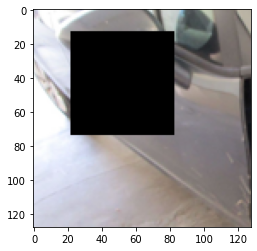

In [128]:
plt.imshow((masked[4]+1)/2)

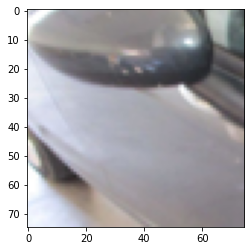

In [127]:
plt.imshow((missing[4]+1)/2)

In [131]:
res = ce.autoencoder.predict(masked)

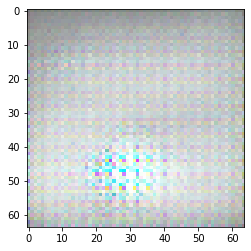

In [126]:
plt.imshow((res[4]+1)/2)

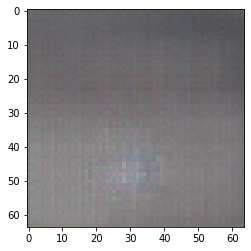

In [132]:
plt.imshow((res[4]+1)/2)

In [ ]:
new_img = 